In [83]:
# use myenv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from tabulate import tabulate

In [22]:
torch.autograd.set_detect_anomaly(True)

In [23]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, index_col=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #sample = self.data.iloc[idx].values
        sample = self.data.iloc[idx].values.astype(np.float32)
        return sample

In [24]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc_encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(input_dim, latent_dim)
        self.logvar_layer = nn.Linear(input_dim, latent_dim)
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def encode(self, x):
        # hidden = self.encoder(x)
        # mu = self.mu_layer(hidden)
        # logvar = self.logvar_layer(hidden)
        # z = self.reparameterize(mu, logvar)
        # return z
        x = x.to(torch.float32)  # Convert x to the appropriate data type
        hidden = self.fc_encoder(x)
        mu = self.mu_layer(hidden)
        logvar = self.logvar_layer(hidden)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        reconstructed = self.fc_decoder(z)
        return reconstructed
        
    def forward(self, x):
        print("Input shape:", x.shape) 
        x = x.to(torch.float32)
        z, _, _ = self.encode(x)
        reconstructed = self.decode(z)
        return reconstructed, z

In [25]:
csv_file = '/Users/jaiuparkar/Downloads/PSTAT199/P3_vert_def_VAE_num_v3.csv'
dataframe = pd.read_csv(csv_file, index_col=0)

In [26]:
dataframe.mean(axis = 0)

deltaFreeFallTime                       -2.380595e-16
ABS Delta Free-Fall Time (Left First)    1.229253e-16
totalMovementTimeRight                  -5.908204e-17
totalMovementTimeLeft                    7.544864e-17
totalMovementImpulseRight               -2.316211e-16
                                             ...     
peakRelativeRotationLeft                -9.293282e-17
deltaRelativeRotationRight              -2.164177e-17
deltaRelativeRotationLeft                1.601491e-17
peakRelativeRotationVelocityRight        8.721635e-17
peakRelativeRotationVelocityLeft         1.164327e-16
Length: 130, dtype: float64

In [27]:
batch_size = 1
input_dim = dataframe.shape[1]  # Number of features in your CSV data
latent_dim = 15  # Dimensionality of the latent space
epochs = 10

In [28]:
dataset = CustomDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [29]:
num_columns = len(dataloader.dataset[0])
print("Dataset size:", num_columns )

Dataset size: 130


In [30]:
# Instantiate VAE model, loss function, and optimizer
vae = VAE(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=0.00001)

In [31]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

VAE(
  (fc_encoder): Sequential(
    (0): Linear(in_features=130, out_features=130, bias=True)
    (1): ReLU()
    (2): Linear(in_features=130, out_features=130, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=130, out_features=15, bias=True)
  (logvar_layer): Linear(in_features=130, out_features=15, bias=True)
  (fc_decoder): Sequential(
    (0): Linear(in_features=15, out_features=130, bias=True)
    (1): ReLU()
    (2): Linear(in_features=130, out_features=130, bias=True)
    (3): ReLU()
    (4): Linear(in_features=130, out_features=130, bias=True)
    (5): Sigmoid()
  )
)

In [32]:
for batch in dataloader:
    inputs = batch.to(device)
    outputs, _ = vae(inputs)

    # Check the shapes of outputs and target data
    if outputs.shape != inputs.shape:
        print("Mismatch in shapes: outputs.shape =", outputs.shape, "inputs.shape =", inputs.shape)

Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: t

In [33]:
for epoch in range(epochs):
    running_loss = 0.0
    for batch in dataloader:
        inputs = batch.to(device)

        optimizer.zero_grad()

        outputs, z = vae(inputs)
        print(outputs.shape)
        print(inputs.shape)
        # Check the shapes of outputs and target data
        if outputs.shape != inputs.shape:
                print("Mismatch in shapes: outputs.shape =", outputs.shape, "inputs.shape =", inputs.shape)
                
        reconstruction_loss = criterion(outputs, inputs)
        z, mu, log_var = vae.encode(inputs)
       # kl_loss = -0.5 * torch.sum(1 + vae.logvar_layer.weight - vae.mu_layer.weight.pow(2) - vae.logvar_layer.weight.exp())
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        loss = reconstruction_loss + kl_loss
        print("Calculated Loss")
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm) IF NEEDED 
        print("Perform Backprop")
        optimizer.step()
        print("Took a step")

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f}")

Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130])
torch.Size([1, 130])
torch.Size([1, 130])
Calculated Loss
Perform Backprop
Took a step
Input shape: torch.Size([1, 130]

In [49]:
weights_path = '/Users/jaiuparkar/Downloads/PSTAT199/vae_weights.pth'
# Save the state dictionary of the model
torch.save(vae.state_dict(), weights_path)

print("Model weights saved successfully.")

Model weights saved successfully.


In [34]:
testing_label = pd.read_csv('/Users/jaiuparkar/Downloads/PSTAT199/P3_vert_def_VAE.csv', index_col=0)

In [47]:
player_pos =  testing_label[testing_label.columns[-1]]
player_label = list(player_pos)

# Convert labels to numerical values
label_mapping = {label: i for i, label in enumerate(set(player_label))}
numerical_labels = [label_mapping[label] for label in player_label]

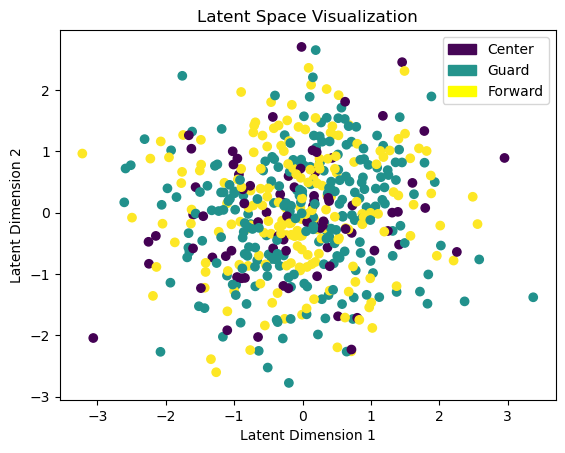

In [88]:
# Create a new dataloader without shuffling
latent_dataloader = DataLoader(dataset, batch_size=batch_size)

# Initialize lists to store latent vectors and corresponding labels
latent_vectors = []
#labels = []

# Encode the data points and collect the latent vectors and labels
with torch.no_grad():
    for batch in latent_dataloader:
        inputs = batch.to(device)
        z, _ , _ = vae.encode(inputs)
        latent_vectors.append(z.cpu().numpy())
        #labels.append(inputs.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
#labels = np.concatenate(labels, axis=0)

legend_dict = { 'Center' : '#460656', 'Guard' : '#24948c', 'Forward' : 'yellow' }

patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

# Visualize the latent space using a scatter plot
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c= numerical_labels)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
#plt.colorbar()
plt.legend(handles=patchList)
plt.show()

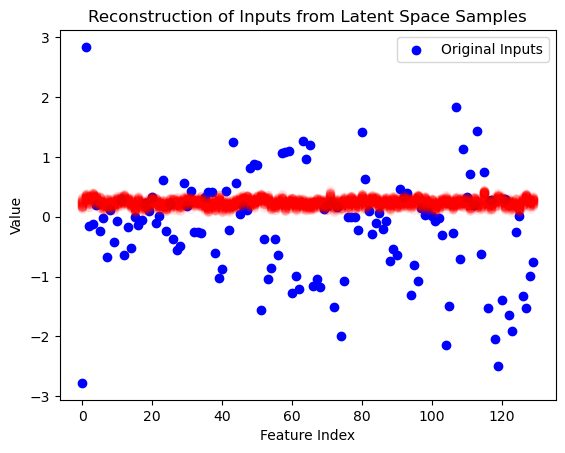

In [91]:
vae = VAE(input_dim, latent_dim)
vae.load_state_dict(torch.load(weights_path))

num_samples = 50  # Number of samples 
latent_samples = torch.randn(num_samples, latent_dim)  # Generate random samples from a standard normal distribution
reconstructed_samples = vae.decode(latent_samples)

# Convert tensors to numpy arrays for plotting
original_inputs = inputs[0].cpu().detach().numpy()
reconstructed_samples = reconstructed_samples.cpu().detach().numpy()

# Create a scatter plot
#plt.figure(figsize=(8, 6))
plt.scatter(range(num_columns), original_inputs, color='blue', label='Original Inputs')
for i in range(num_samples):
    plt.scatter(range(num_columns), reconstructed_samples[i], color='red', alpha=0.05)
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.title('Reconstruction of Inputs from Latent Space Samples')
plt.legend()
plt.show()

In [56]:
# Randomly select 5 indices
random_indices = np.random.choice(len(dataset), size=5, replace=False)

# Get the corresponding data samples
random_samples = [dataset[i] for i in random_indices]

# Convert the data samples to tensors
random_samples = torch.stack([torch.tensor(sample) for sample in random_samples])

# Move the samples to the device (GPU if available)
random_samples = random_samples.to(device)

# Pass the samples through the VAE to get the reconstructed outputs
with torch.no_grad():
    reconstructed_samples, _ = vae(random_samples)

# Convert the tensors to numpy arrays
random_samples_np = random_samples.cpu().detach().numpy()
reconstructed_samples_np = reconstructed_samples.cpu().detach().numpy()

# Print the original input and reconstructed outputs
for i in range(5):
    original = random_samples_np[i].tolist()
    reconstructed = reconstructed_samples_np[i].tolist()
    print("Original:", original)
    print("Reconstructed:", reconstructed)
    print()

Input shape: torch.Size([5, 130])
Original: [-0.5519086718559265, 0.06059356406331062, 1.3229045867919922, 1.32374906539917, 0.6018795967102051, 1.2481322288513184, 0.9464468955993652, 0.22571657598018646, 0.2304411381483078, -0.31692978739738464, 0.05883191525936127, -0.5625860095024109, -0.5722852349281311, -0.5934956669807434, -0.31533604860305786, -0.03459775447845459, -0.1189485415816307, 0.03138184919953346, -0.2904341220855713, -0.13234075903892517, 0.8879879117012024, 0.4511506259441376, 0.6726263761520386, 0.9260118007659912, 1.1315677165985107, 1.1480591297149658, -0.7210420370101929, -0.6607047319412231, -0.7269952893257141, -0.06743067502975464, 0.7568327784538269, 0.3770601749420166, 0.3954273462295532, -0.11265427619218826, 0.14404673874378204, -0.5867305994033813, 0.574195146560669, -0.04025188088417053, 0.6378183364868164, 0.6096808910369873, 2.141165018081665, 1.9814194440841675, 1.2602691650390625, 1.1049317121505737, 1.2939937114715576, 1.1813182830810547, 1.04892277

In [57]:
vae.eval()

# Create empty lists to store the original data and reconstructed data
original_data = []
reconstructed_data = []

# Iterate over the data loader
for batch in dataloader:
    inputs = batch.to(device)

    # Obtain the reconstructed outputs from the VAE
    with torch.no_grad():
        outputs, _ = vae(inputs)

    # Convert the tensors to numpy arrays
    inputs_np = inputs.cpu().numpy()
    outputs_np = outputs.cpu().numpy()

    # Append the data points to the respective lists
    original_data.extend(inputs_np.tolist())
    reconstructed_data.extend(outputs_np.tolist())

# Convert the lists to numpy arrays
original_data = np.array(original_data)
reconstructed_data = np.array(reconstructed_data)


Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: torch.Size([1, 130])
Input shape: t

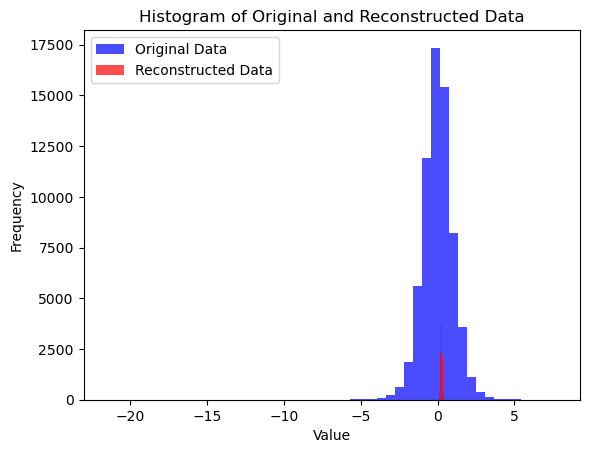

In [76]:
# Flatten the original and reconstructed data into single arrays
flattened_original_data = np.concatenate(original_data)
flattened_reconstructed_data = np.concatenate(reconstructed_data)

# Plot the histograms
plt.hist(flattened_original_data, bins=50, alpha=0.7, color='blue', label='Original Data')
plt.hist(flattened_reconstructed_data, bins=50, alpha=0.7, color='red', label='Reconstructed Data')
plt.title('Histogram of Original and Reconstructed Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()